# Code Vulnerability Detection Using AST, CFG, and PDG Features
## CWE-121 (Stack Based Buffer Overflow)

In [59]:
import csv
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import shap


In [60]:
header_rows = []

with open("cpg_features_cwe121.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        header_rows.append(row)
        if "checks_per_sink" in row:
            break

columns = []
for row in header_rows:
    for cell in row:
        if cell.strip():
            columns.append(cell.strip())

df = pd.read_csv(
    "cpg_features_cwe121.csv",
    skiprows=len(header_rows),
    header=None
)

df.columns = columns


The dataset is generated by a static analysis pipeline that extracts features from
AST, CFG, and PDG representations.

Because the CSV file contains a multi-row hierarchical header, the header rows are
manually reconstructed into a single flat feature vector to preserve semantic correctness.


In [61]:
print(df.head())
print(df.shape)
print(df.columns)


                                                  id  label  ast_nodes  \
0  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...      1        187   
1                                            goodG2B      0         52   
2                                            goodB2G      0        192   
3  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...      1        193   
4                                           goodB2G1      0        202   

   call_count  control_count  identifier_count  literal_count  max_ast_depth  \
0          71             11                42             25             14   
1          16              3                13              9             10   
2          73             11                43             26             14   
3          71             13                42             27             16   
4          74             14                43             29             16   

   input_call_count  conversion_call_count  ...  bounds_check_count  \
0  

Each row corresponds to a program slice, and each column represents a structural or semantic feature derived from program analysis.


In [62]:
X = df.drop(columns=["id", "label"])
y = df["label"]


The task is formulated as a binary classification problem:

- **label = 1** → vulnerable
- **label = 0** → non-vulnerable

The `id` column is excluded as it carries no predictive information.


In [63]:
bool_cols = ["taint_reachable", "sink_inside_loop"]
X[bool_cols] = X[bool_cols].astype(int)


Boolean features produced by taint and control-flow analysis are converted to integer
values to ensure compatibility with machine learning algorithms.


In [64]:
y.value_counts()


label
0    2533
1    1458
Name: count, dtype: int64

In [65]:
constant_features = [
    col for col in X.columns
    if X[col].nunique() <= 1
]

near_constant = []
for col in X.columns:
    top_freq = X[col].value_counts(normalize=True).iloc[0]
    if top_freq > 0.99:
        near_constant.append((col, top_freq))

print("Constant features:", constant_features)
print("Near-constant features (>99% same value):", near_constant)


Constant features: ['exec_call_count', 'branch_count', 'loop_count', 'cyclomatic_complexity', 'taint_reachable', 'sink_inside_loop']
Near-constant features (>99% same value): [('exec_call_count', np.float64(1.0)), ('branch_count', np.float64(1.0)), ('loop_count', np.float64(1.0)), ('return_count', np.float64(0.9964921072412929)), ('cyclomatic_complexity', np.float64(1.0)), ('taint_reachable', np.float64(1.0)), ('sink_inside_loop', np.float64(1.0))]


Features with zero variance provide no discriminative power and are removed.
Near-constant features are retained but analyzed to assess potential redundancy.


In [66]:
X_reduced = X.drop(columns=constant_features)

print("Original shape:", X.shape)
print("Reduced shape:", X_reduced.shape)


Original shape: (3991, 27)
Reduced shape: (3991, 21)


Only strictly constant features are removed to avoid premature loss of potentially
meaningful but skewed structural signals.


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


A stratified split ensures that the vulnerability ratio is preserved across training
and test sets, preventing optimistic bias.


In [68]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train_s, y_train)

y_pred = lr.predict(X_test_s)
y_prob = lr.predict_proba(X_test_s)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.82      0.68      0.75       507
           1       0.58      0.75      0.65       292

    accuracy                           0.71       799
   macro avg       0.70      0.72      0.70       799
weighted avg       0.73      0.71      0.71       799

ROC-AUC: 0.7590682499797359


Logistic Regression serves as a transparent baseline model.
Its coefficients provide insight into linear associations between program structure
and vulnerability presence.


In [69]:
coef_df = (
    pd.DataFrame({
        "feature": X_reduced.columns,
        "coefficient": lr.coef_[0]
    })
    .sort_values("coefficient", ascending=False)
)

coef_df.head(10)


,feature,coefficient
3,identifier_count,3.168652
18,use_count,3.168652
2,control_count,1.630576
19,calls_per_ast_node,1.536039
4,literal_count,0.851681
6,input_call_count,0.564003
7,conversion_call_count,0.564003
8,memory_call_count,0.151202
9,format_call_count,0.115610
13,bounds_check_count,-0.013016


Positive coefficients indicate features associated with increased vulnerability risk,
while negative coefficients suggest protective structural patterns.


In [70]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       507
           1       0.88      0.80      0.84       292

    accuracy                           0.89       799
   macro avg       0.88      0.87      0.88       799
weighted avg       0.89      0.89      0.89       799

ROC-AUC: 0.9713936397287293


Random Forests are well-suited for modeling nonlinear interactions between heterogeneous
AST, CFG, and PDG features.


In [71]:
rf_imp = (
    pd.DataFrame({
        "feature": X_reduced.columns,
        "importance": rf.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

rf_imp.head(10)


,feature,importance
19,calls_per_ast_node,0.291424
0,ast_nodes,0.224793
1,call_count,0.070456
4,literal_count,0.059266
2,control_count,0.055766
17,def_count,0.051198
3,identifier_count,0.050559
18,use_count,0.049990
5,max_ast_depth,0.041021
15,array_write_count,0.031919


Tree-based importance provides an initial ranking of influential structural features.


In [72]:
perm = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring="f1"
)

perm_df = (
    pd.DataFrame({
        "feature": X_reduced.columns,
        "importance": perm.importances_mean
    })
    .sort_values("importance", ascending=False)
)

perm_df.head(10)


,feature,importance
19,calls_per_ast_node,0.336800
0,ast_nodes,0.244318
2,control_count,0.043831
5,max_ast_depth,0.042221
17,def_count,0.029876
3,identifier_count,0.021646
11,address_of_count,0.021108
4,literal_count,0.018164
18,use_count,0.015476
15,array_write_count,0.004935


Permutation importance measures the true predictive dependence of the model on each
feature, independent of internal model bias.


In [73]:
k = 9

top_features = (
    perm_df
    .sort_values("importance", ascending=False)
    .head(k)["feature"]
    .tolist()
)

X_min = X_reduced[top_features]

print("Selected top features:")
for f in top_features:
    print("-", f)

print("\nReduced feature set shape:", X_min.shape)


Selected top features:
- calls_per_ast_node
- ast_nodes
- control_count
- max_ast_depth
- def_count
- identifier_count
- address_of_count
- literal_count
- use_count

Reduced feature set shape: (3991, 9)


The selected features primarily capture structural properties of programs, including
syntax tree complexity, symbol usage patterns, control-flow characteristics, and
memory-related operations.

Such features are commonly associated with software vulnerabilities, as they reflect
how data and control propagate through a program and how memory-related constructs
are used.

In [74]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_min,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf_min = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_min.fit(X_train_m, y_train_m)

pred = rf_min.predict(X_test_m)
prob = rf_min.predict_proba(X_test_m)[:, 1]

print(classification_report(y_test_m, pred))
print("ROC-AUC:", roc_auc_score(y_test_m, prob))


              precision    recall  f1-score   support

           0       0.93      0.96      0.94       507
           1       0.92      0.88      0.90       292

    accuracy                           0.93       799
   macro avg       0.93      0.92      0.92       799
weighted avg       0.93      0.93      0.93       799

ROC-AUC: 0.9803470589824647


Despite using a significantly reduced number of features, the model achieves strong
classification performance, indicating that vulnerability detection relies on a
limited set of highly informative structural signals.

This result suggests that high-dimensional feature representations are not strictly
necessary and that compact, interpretable feature sets can be effective for
vulnerability detection tasks.


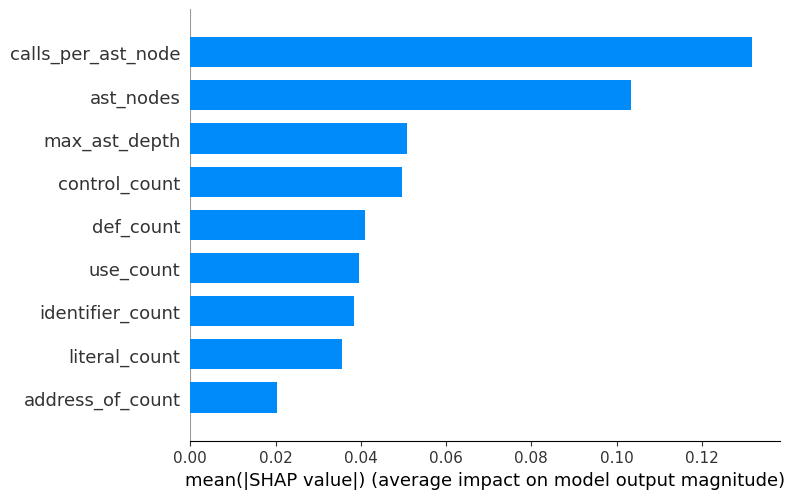

In [75]:
explainer = shap.TreeExplainer(rf_min)
shap_values = explainer.shap_values(X_test_m)

shap.summary_plot(
    shap_values[:, :, 1],
    X_test_m,
    plot_type="bar"
)


SHAP (SHapley Additive exPlanations) analysis is used to provide global explanations
of the model’s predictions. The resulting feature importance ranking highlights how
individual structural features contribute to vulnerability classification decisions.

This improves model transparency and supports qualitative analysis of which program
properties are most strongly associated with vulnerabilities.


Structural features related to program size may introduce bias, as larger code
fragments naturally contain more syntactic and semantic elements. To evaluate whether
the model relies excessively on such size-related information, an additional
experiment is conducted where explicit size features are removed when present.


In [76]:
size_features = [
    f for f in top_features
    if "ast" in f.lower() or "node" in f.lower()
]

features_no_size = [f for f in top_features if f not in size_features]

X_no_size = X_reduced[features_no_size]

print("Removed size-related features:", size_features)
print("Remaining features:", features_no_size)
print("Shape without size features:", X_no_size.shape)


Removed size-related features: ['calls_per_ast_node', 'ast_nodes', 'max_ast_depth']
Remaining features: ['control_count', 'def_count', 'identifier_count', 'address_of_count', 'literal_count', 'use_count']
Shape without size features: (3991, 6)


In [77]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_no_size,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf_no_size = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_no_size.fit(X_train_ns, y_train_ns)

pred_ns = rf_no_size.predict(X_test_ns)
prob_ns = rf_no_size.predict_proba(X_test_ns)[:, 1]

print("=== Random Forest (without size-related features) ===")
print(classification_report(y_test_ns, pred_ns))
print("ROC-AUC:", roc_auc_score(y_test_ns, prob_ns))


=== Random Forest (without size-related features) ===
              precision    recall  f1-score   support

           0       0.80      0.54      0.64       507
           1       0.49      0.76      0.60       292

    accuracy                           0.62       799
   macro avg       0.64      0.65      0.62       799
weighted avg       0.69      0.62      0.63       799

ROC-AUC: 0.6671091026991977
